# 5. Multiple sensors and correlations
## Task 

Estimate the elastic modulus ($E$) of a simply supported bean from a measured deflections ($\delta_{\text{measured},1}$,$\delta_{\text{measured},2}$). Notice that this is the same problem as the task in **exercise 4** with one more vertical translation sensor and we have only uncertainty and no measurement uncertainty. 

```{figure} ../figures/multiplesensors_example.png
:alt: numerical integration example
:width: 300px
:align: center
```

Assume that we know the following:

- The measurement uncertainty of deflection follows a normal distribution with zero
mean and 1 cm standard deviation.
- The measurement uncertainty is additive:

$\delta_\text{measured} = \delta_\text{real} + \text{measurement}_\text{unc}$

- There is no measure uncertainty: $\delta_\text{measured} = \delta_\text{real}$.
- Model uncertainties at the measurement points are correlated: their joint distribution can be described by a bivariate normal distribution:
    - With marginals as described above.
    - With a (Pearson) correlation of 0.5 ($\rho$).

- We have a single deflection measurement: $\delta_{\text{measured},1} = 5$ cm, $\delta_{\text{measured},2} = 3.5$ cm
- The second sensor is positioned at $x=L/4$ 
- The second moment of area (flexural inertia) of the beam is known, $I = 1×10^5$ $\text{cm}^4$.
- The span of the beam is known, L = 10 m.
- The self weight of the beam can be neglected, and it is loaded solely by a point load at the midspan with intensity, Q = 100 kN.
- Bernoulli-Navier beam theory dis applicable, the material is linear elastic, the hinges at bot ends are perfec/idealized

### Question

Question: What is the posterior of $E$? Assume a normal distribution on $E$ as prior with small information content (flat prior with a huge standard deviation).


:::{hint}
:class: dropdown

$\delta_{x<L/2} = \frac{Qx(3L^2-4x^2)}{48EI}$

In Probeye, correlations are introduced via correlation functions. Calculate what should be the correlation length to obtain the desired Pearson correlation coefficient. You can use the default Exponential function:

$\rho = \text{exp} \left(\frac{||x-x'||}{l_{corr}} \right)$

check Probeye example -Linear regression with 1D correlation- 
:::

## Imports

In [ ]:
import numpy as np

# Problem definition
from probeye.definition.inverse_problem import InverseProblem
from probeye.definition.forward_model import ForwardModelBase
from probeye.definition.distribution import Normal
from probeye.definition.sensor import Sensor
from probeye.definition.likelihood_model import GaussianLikelihoodModel
from probeye.definition.correlation_model import ExpModel

# Inference
from probeye.inference.emcee.solver import EmceeSolver

# Postprocessing
from probeye.postprocessing.sampling_plots import create_posterior_plot

## Problem setup

In [2]:
# Fixed parameters
I = 1e9  # mm^4
L = 10_000  # mm
Q = 100  # kN

# Measurements
x_sensors = [2500, 5000]  # mm  (always from lower to higher, bug in inv_cov_vec_1D in tripy)
d_sensors = [35, 50]  # mm
sigma_model = 10  # mm
pearson = 0.5
l_corr = -np.abs(x_sensors[1] - x_sensors[0]) / np.log(pearson)  # mm (assuming exponential correlation)

# Prior
E_mean = 60  # GPa
E_std = 20  # GPa

## Define forward model

In [3]:
def beam_deflection(E, x):  # x is sensor position
    return Q * x * (3 * L ** 2 - 4 * x ** 2) / (48 * E * I)

In [4]:
class BeamModel(ForwardModelBase):
    def interface(self):
        self.parameters = ["E"]
        self.input_sensors = Sensor("x")
        self.output_sensors = Sensor("y", std_model="sigma")

    def response(self, inp: dict) -> dict:
        E = inp["E"]
        x = inp["x"]
        return {"y": [beam_deflection(E, float(x[0])), beam_deflection(E, float(x[1]))]}  # float() needed, probably a bug in probeye

## Define inverse problem

In [5]:
# Instantiate the inverse problem
problem = InverseProblem("Beam model with two sensors", print_header=False)

# Add latent parameters
problem.add_parameter(
    "E",
    tex="$E$",
    info="Elastic modulus of the beam (GPa)",
    prior=Normal(mean=E_mean, std=E_std),
)

# Add fixed parameters
problem.add_parameter(
    "sigma",
    tex="$\sigma$",
    info="Standard deviation of the model error (mm)",
    value=sigma_model,
)
problem.add_parameter(
    "l_corr",
    tex="$l_{corr}$",
    info="Correlation length of the model error (mm)",
    value=l_corr,
)

# Add measurement data
problem.add_experiment(
    name="TestSeries_1",
    sensor_data={"x": x_sensors, "y": d_sensors}
)
                 
# Add forward model
problem.add_forward_model(BeamModel("BeamModel"), experiments="TestSeries_1")

# Add likelihood model
likelihood_model = GaussianLikelihoodModel(
        experiment_name="TestSeries_1", 
        model_error="additive",
        correlation=ExpModel(x="l_corr")
        )
problem.add_likelihood_model(likelihood_model)


## Solve with MCMC

In [6]:
emcee_solver = EmceeSolver(problem, show_progress=True)
inference_data = emcee_solver.run(n_steps=2000, n_initial_steps=2000)

2024-07-08 21:20:41.409 | INFO     | Solving problem using emcee sampler with 2000 + 2000 samples and 20 walkers                          | probeye.inference.emcee.solver:run:178
2024-07-08 21:20:41.411 | INFO     | No additional options specified                                                                      | probeye.inference.emcee.solver:run:186


100%|██████████| 2000/2000 [00:08<00:00, 228.65it/s]

2024-07-08 21:20:59.714 | INFO     | Sampling of the posterior distribution completed: 2000 steps and 20 walkers.                         | probeye.inference.emcee.solver:run:255
2024-07-08 21:20:59.715 | INFO     | Total run-time (including initial sampling): 18s.                                                    | probeye.inference.emcee.solver:run:259
2024-07-08 21:20:59.715 | INFO     |                                                                                                      | probeye.inference.emcee.solver:run:260
2024-07-08 21:20:59.716 | INFO     | Summary of sampling results (emcee)                                                                  | probeye.inference.emcee.solver:run:261
2024-07-08 21:20:59.719 | INFO     |       mean    median     sd     5%    95%                                                            | probeye.inference.emcee.solver:emcee_summary:137
2024-07-08 21:20:59.720 | INFO     | --  ------  --------  -----  -----  -----                 

## Plot

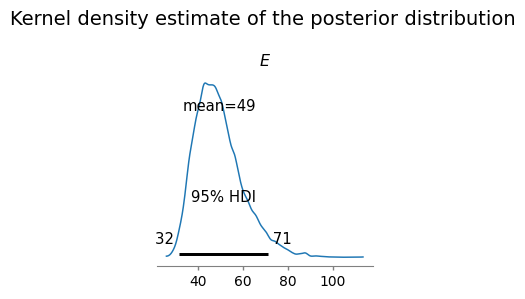

In [7]:
post_plot_array = create_posterior_plot(
    inference_data,
    emcee_solver.problem,
    kind="kde",
    title="Kernel density estimate of the posterior distribution",
)

:::{note} Complete Code! 📃💻
:class: dropdown
Here’s the complete code that you would run in your PC:

```python

import numpy as np

# Problem definition
from probeye.definition.inverse_problem import InverseProblem
from probeye.definition.forward_model import ForwardModelBase
from probeye.definition.distribution import Normal
from probeye.definition.sensor import Sensor
from probeye.definition.likelihood_model import GaussianLikelihoodModel
from probeye.definition.correlation_model import ExpModel

# Inference
from probeye.inference.emcee.solver import EmceeSolver

# Postprocessing
from probeye.postprocessing.sampling_plots import create_posterior_plot

# Fixed parameters
I = 1e9  # mm^4
L = 10_000  # mm
Q = 100  # kN

# Measurements
x_sensors = [2500, 5000]  # mm  (always from lower to higher, bug in inv_cov_vec_1D in tripy)
d_sensors = [35, 50]  # mm
sigma_model = 10  # mm
pearson = 0.5
l_corr = -np.abs(x_sensors[1] - x_sensors[0]) / np.log(pearson)  # mm (assuming exponential correlation)

# Prior
E_mean = 60  # GPa
E_std = 20  # GPa

def beam_deflection(E, x):  # x is sensor position
    return Q * x * (3 * L ** 2 - 4 * x ** 2) / (48 * E * I)
	
# Instantiate the inverse problem
problem = InverseProblem("Beam model with two sensors", print_header=False)

# Add latent parameters
problem.add_parameter(
    "E",
    tex="$E$",
    info="Elastic modulus of the beam (GPa)",
    prior=Normal(mean=E_mean, std=E_std),
)

# Add fixed parameters
problem.add_parameter(
    "sigma",
    tex="$\sigma$",
    info="Standard deviation of the model error (mm)",
    value=sigma_model,
)
problem.add_parameter(
    "l_corr",
    tex="$l_{corr}$",
    info="Correlation length of the model error (mm)",
    value=l_corr,
)

# Add measurement data
problem.add_experiment(
    name="TestSeries_1",
    sensor_data={"x": x_sensors, "y": d_sensors}
)
                 
# Add forward model
problem.add_forward_model(BeamModel("BeamModel"), experiments="TestSeries_1")

# Add likelihood model
likelihood_model = GaussianLikelihoodModel(
        experiment_name="TestSeries_1", 
        model_error="additive",
        correlation=ExpModel(x="l_corr")
        )
problem.add_likelihood_model(likelihood_model)


#solve with MCMC
emcee_solver = EmceeSolver(problem, show_progress=True)
inference_data = emcee_solver.run(n_steps=2000, n_initial_steps=2000)

#Plot
post_plot_array = create_posterior_plot(
    inference_data,
    emcee_solver.problem,
    kind="kde",
    title="Kernel density estimate of the posterior distribution",
)

```
:::